# Complete Attack to Recover the 6th Byte of the Key

This notebook shows a complete attack to a single byte, specifically byte 5.

**The train-configuration is composed by 2 devices (D1, D2) and all possible keys (all device-key permutations)**, exept K0, which is attacked.\
**The attack-configuration is D3-K0**.\
The scenario is **Multiple Device Model (MDM)**, where multiple devices are used in training and a different device is attacked.

The following results and metrics are shown:
* **Train Loss & Validation Loss**
* **Train Accuracy & Validation Accuracy**
* **Attack Loss & Attack Accuracy**
* **Confusion Matrix**
* **Guessing Entropy**

In [1]:
# Basics
import numpy as np
import json
from tqdm import tqdm
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Custom
import sys
sys.path.insert(0, '../src/utils')
from data_loader import DataLoader, SplitDataLoader
import helpers
import constants
import results
sys.path.insert(0, '../src/modeling')
from network import Network

# Suppress TensorFlow messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # 1 for INFO, 2 for INFO & WARNINGs, 3 for INFO & WARNINGs & ERRORs

In [2]:
def plot_history(history, output_path):
    
    """
    Plots the training history (train_loss vs val_loss, train_acc vs val_acc).
    
    Parameters:
        - history (dict):
            Train history.
        - output_path (str):
            Absolute path to the PNG file containing the plot.
    """
    
    f, ax = plt.subplots(1, 2, figsize=(18,8))
    
    ax[0].plot(history['loss'], label='train_loss')
    ax[0].plot(history['val_loss'], label='val_loss')
    ax[0].set_title('Train and Val Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].legend()
    ax[0].grid()
    
    ax[1].plot(history['accuracy'], label='train_acc')
    ax[1].plot(history['val_accuracy'], label='val_acc')
    ax[1].set_title('Train and Val Acc')
    ax[1].set_ylabel('Acc')
    ax[1].set_xlabel('Epochs')
    ax[1].legend()
    ax[1].grid()
    
    f.savefig(
        output_path, 
        bbox_inches='tight', 
        dpi=600
    )
    
    plt.show()
    
    plt.close(f)
    
    
def plot_conf_matrix(conf_matrix, output_path):
    
    cmap = plt.cm.Blues
    
    f = plt.figure(figsize=(10,8))
    
    plt.imshow(conf_matrix, cmap=cmap)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    
    plt.colorbar()
    
    f.savefig(
        output_path,
        bbox_inches='tight',
        dpi=600
    )
    
    plt.show()
    
    plt.close(f)
    
    
def plot_ge(ge, output_path):

    """
    Plots the provided GE vector.
    
    Parameters:
        - ge (np.array):
            GE vector to plot.
        - output_path (str):
            Absolute path to the PNG file containing the plot.
    """
    
    ge = ge[:15]
    
    # Plot GE
    f, ax = plt.subplots(figsize=(15,8))
    
    ax.plot(ge, marker='o', color='b')
        
    ax.set_title(f'Train Devices: D1, D2  |  Test Device: D3')
    ax.set_xticks(range(len(ge)), labels=range(1, len(ge)+1)) 
    ax.set_xlabel('Number of traces')
    ax.set_ylabel('GE')
    ax.grid()

    f.savefig(
        output_path, 
        bbox_inches='tight', 
        dpi=600
    )
    
    plt.show()
    
    plt.close(f)

In [3]:
RES_ROOT = f'{constants.RESULTS_PATH}/DKTA/SBOX_OUT/byte5/2d' 
HP_PATH = RES_ROOT + '/hp.json'

SINGLE_ATTACK_FOLDER = f'{constants.RESULTS_PATH}/SingleAttack_Byte5'
MODEL_PATH = SINGLE_ATTACK_FOLDER + f'/model_b5.h5'
HISTORY_PATH = SINGLE_ATTACK_FOLDER + '/train_history.png'
CONF_MATRIX_PATH = SINGLE_ATTACK_FOLDER + '/conf_matrix.png'
GE_FILE_PATH = SINGLE_ATTACK_FOLDER + '/ge.npy'
GE_PLOT_PATH = SINGLE_ATTACK_FOLDER + '/ge.png'

TRAIN_DEVS = ['D1', 'D2']
ATTACKED_CONFIG = 'D3-K0'

## Training

In [4]:
# Get train data
train_configs = [f'{d}-{k}' for k in list(constants.KEYS)[1:]
                 for d in TRAIN_DEVS]

train_dl = SplitDataLoader(
    train_configs, 
    n_tot_traces=100000,
    train_size=0.9,
    target='SBOX_OUT',
    byte_idx=5
)
train_data, val_data = train_dl.load()
x_train, y_train, _, _ = train_data 
x_val, y_val, _, _ = val_data


# Get hyperparameters
with open(HP_PATH, 'r') as jfile:
    hp = json.load(jfile)


# Train and save the model
net = Network('MLP', hp)
net.build_model()
net.add_checkpoint_callback(MODEL_PATH)
model = net.model

history = model.fit(
    x_train, 
    y_train, 
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=net.hp['batch_size'],
    callbacks=net.callbacks,
    verbose=0
).history

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (Dense)               (None, 1183)              1400672   
                                                                 
 InputBatchNorm (BatchNormal  (None, 1183)             4732      
 ization)                                                        
                                                                 
 HiddenDropout0 (Dropout)    (None, 1183)              0         
                                                                 
 HiddenDense0 (Dense)        (None, 200)               236800    
                                                                 
 HiddenBatchNorm0 (BatchNorm  (None, 200)              800       
 alization)                                                      
                                                                 
 HiddenDropout1 (Dropout)    (None, 200)               0

The summary shows the **strucure of the model** and the **number of parameters per layer**.

### Training History

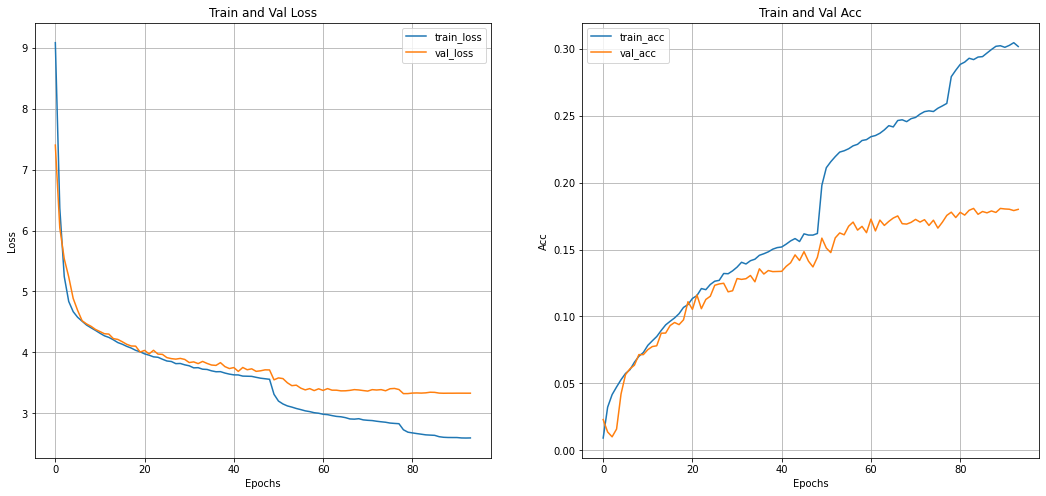

In [6]:
plot_history(history, HISTORY_PATH)

**Validation metrics follow train metrics without diverging**, showing that **the model is not overfitting** the data.

The two *jumps* around epoch 50 and epoch 80 are consequences of the "**Reduce Learning Rate on Plateau**" **callback**, which is applied during training.\
The applied callback **reduces the learning rate if a given metric stops improving**.\
In this case, **the monitored metric is val_loss**, meaning that the callback is activated every time it stops decreasing (after a specified number of epochs).\

## Attack

In [7]:
attack_dl = DataLoader(
    [ATTACKED_CONFIG], 
    n_tot_traces=5000,
    target='SBOX_OUT',
    byte_idx=5
)
x_attack, y_attack, pbs_attack, tkb_attack = attack_dl.load()

attack_model = load_model(MODEL_PATH)
preds = attack_model.predict(x_attack)

### Attack Loss & Attack Accuracy

In [8]:
attack_loss, attack_acc = attack_model.evaluate(x_attack, y_attack, verbose=0)

print(f'Attack Loss:     {attack_loss:.2f}')
print(f'Attack Accuracy: {(attack_acc*100):.2f}%')

Attack Loss:     4.11
Attack Accuracy: 11.20%


The obtained results are not the best for a classical classification problem, but they are **enough for this specific scenario**.\
Indeed, **in Deep Learning based SCAs there is the additional step of "combining the single predictions", because all the input data share the true objective of the attack, the key**.\

However, it is interesting to see the values of the metrics because both hyperparameter tuning and training callbacks are based on them, specifically on validation loss.

### Confusion Matrix

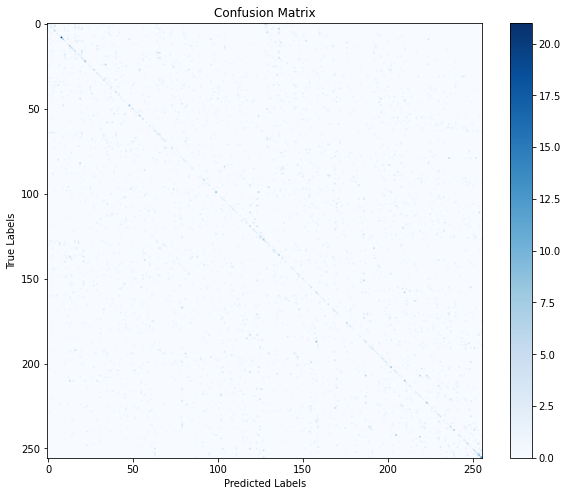

In [9]:
# From one-hot-encoding to true labels in [0;255]
y_true = [el.tolist().index(1) for el in y_attack] 
y_pred = [el.tolist().index(max(el)) for el in preds]

conf_matrix = confusion_matrix(y_true, y_pred)

plot_conf_matrix(conf_matrix, CONF_MATRIX_PATH)

The ideal confusion matrix has values only on the main diagonal (each predicted label matches the corresponding true label).\
In this case there are misclassifications, but **the main diagonal is still clearly visible**, meaning that the model is not a random guesser.

The **misclassifications are consequence of the low attack accuracy** (~11%).\
However, **this result is good enough to allow the correct key-byte recovery**.

### Guessing Entropy

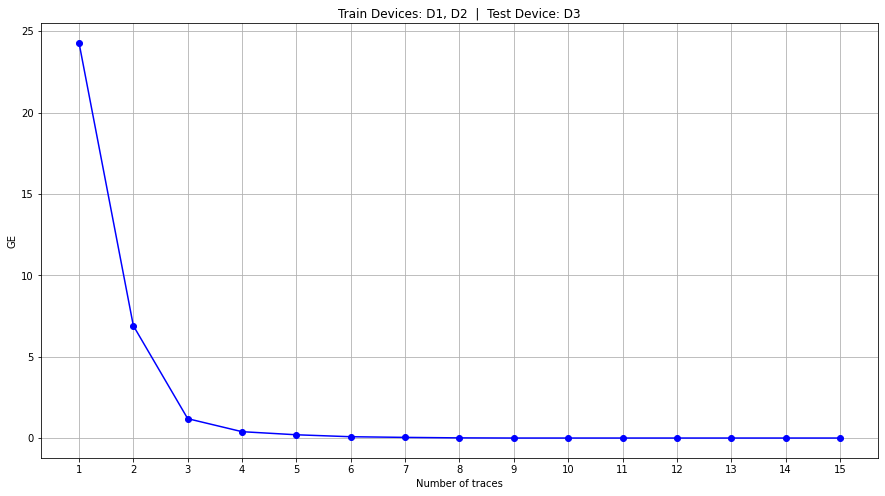

In [10]:
ge = results.ge(
    preds=preds, 
    pltxt_bytes=pbs_attack, 
    true_key_byte=tkb_attack, 
    n_exp=100, 
    target='SBOX_OUT',
    n_traces=100
)

np.save(GE_FILE_PATH, ge)

plot_ge(ge, GE_PLOT_PATH)

The overall performance is very good: **GE reaches 0 in less than 10 traces**, allowing the recovery of the 6th byte of the key considering only 6 attack traces (on average).

This result shows how in Deep Learning based SCAs accuracy should not be the reference metric: **a model with high accuracy will surely perform well, but a model with low accuracy cannot be discarded a priori**.

### Byte Recovery

In [11]:
ATTACKED_KEY = np.array([int(kb, 16) for kb in constants.KEYS['K0']])
BYTE_6 = ATTACKED_KEY[5]

predicted_byte_inc_traces = results.retrieve_key_byte(
    preds=preds, 
    pltxt_bytes=pbs_attack,  
    target='SBOX_OUT',
    n_traces=100
).tolist()

correct_byte_idx = predicted_byte_inc_traces.index(BYTE_6)
predicted_byte = predicted_byte_inc_traces[correct_byte_idx]

print(f'Predicted 6th Byte: {predicted_byte}')
print(f'Correct 6th Byte:   {BYTE_6}')

Predicted 6th Byte: 253
Correct 6th Byte:   253


The attacked byte is **correctly recovered**.